# Optimization-based Control with CasADi

In [ ]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T_final = 50
N = 300  # number of discretization intervals
dt = T_final / N

k_f = 0.2  # friction/damping coefficient
k_u = 1.0  # control gain
v_h = 0.5  # human walking speed (m/s)
d_target = 1.5  # target distance (m)

# Initial conditions
d_0 = 3.0  # initial distance (m)
v_r_0 = 0.0  # initial robot velocity (m/s)

In [ ]:
# Define the ODE: x = [d, v_r], u = control input
def ode(x, u):
    d = x[0]
    v_r = x[1]
    dd_dt = v_h - v_r
    dv_r_dt = -k_f * v_r + k_u * u
    return ca.vertcat(dd_dt, dv_r_dt)


# Build the NLP using CasADi's Opti interface
opti = ca.Opti()

# Decision variables: states and controls at each grid point
X = opti.variable(2, N + 1)  # states: [d; v_r] at t_0 ... t_N
U = opti.variable(1, N + 1)  # control u at t_0 ... t_N

# Initial conditions
opti.subject_to(X[0, 0] == d_0)
opti.subject_to(X[1, 0] == v_r_0)

# Control bounds
opti.subject_to(opti.bounded(-1.0, U, 1.0))

In [ ]:
# Dynamics constraints (backward Euler) and running cost
cost = 0
for k in range(N):
    # Backward Euler: x_{k+1} - x_k = dt * f(x_{k+1}, u_{k+1})
    x_next = X[:, k + 1]
    u_next = U[:, k + 1]
    opti.subject_to(x_next - X[:, k] == dt * ode(x_next, u_next))

    # Running cost (trapezoidal quadrature to approximate the integral)
    stage_k = U[:, k] ** 2 + (X[0, k] - d_target) ** 2
    stage_k1 = u_next**2 + (x_next[0] - d_target) ** 2
    cost += 0.5 * dt * (stage_k + stage_k1)

# Terminal cost
cost += (X[0, N] - d_target) ** 2

opti.minimize(cost)

In [4]:
# Solve with IPOPT
opti.solver("ipopt", {"print_time": False}, {"print_level": 0})
sol = opti.solve()

# Extract solution
t_grid = np.linspace(0, T_final, N + 1)
d_sol = sol.value(X[0, :]).flatten()
v_r_sol = sol.value(X[1, :]).flatten()
u_sol = sol.value(U).flatten()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [5]:
u_sol

array([ 0.        ,  1.00000001,  1.00000001,  1.        ,  1.        ,
        1.        ,  0.99999998,  0.98891489,  0.76567051,  0.57324873,
        0.40983616,  0.27329484,  0.16128435,  0.07136127,  0.00106011,
       -0.05204207, -0.09027589, -0.11584242, -0.13078704, -0.13698253,
       -0.13611994, -0.12970575, -0.11906419, -0.1053434 , -0.08952462,
       -0.07243352, -0.05475287, -0.03703606, -0.01972087, -0.0031432 ,
        0.01244966,  0.0268864 ,  0.04005981,  0.05191593,  0.06244414,
        0.07166831,  0.07963893,  0.08642631,  0.0921147 ,  0.09679728,
        0.10057206,  0.10353846,  0.10579458,  0.10743515,  0.10854989,
        0.10922241,  0.10952946,  0.10954049,  0.10931756,  0.10891531,
        0.10838126,  0.1077561 ,  0.10707421,  0.10636407,  0.10564887,
        0.10494705,  0.10427282,  0.10363676,  0.10304626,  0.10250609,
        0.10201876,  0.10158499,  0.10120403,  0.10087401,  0.10059224,
        0.10035539,  0.10015976,  0.10000143,  0.09987639,  0.09

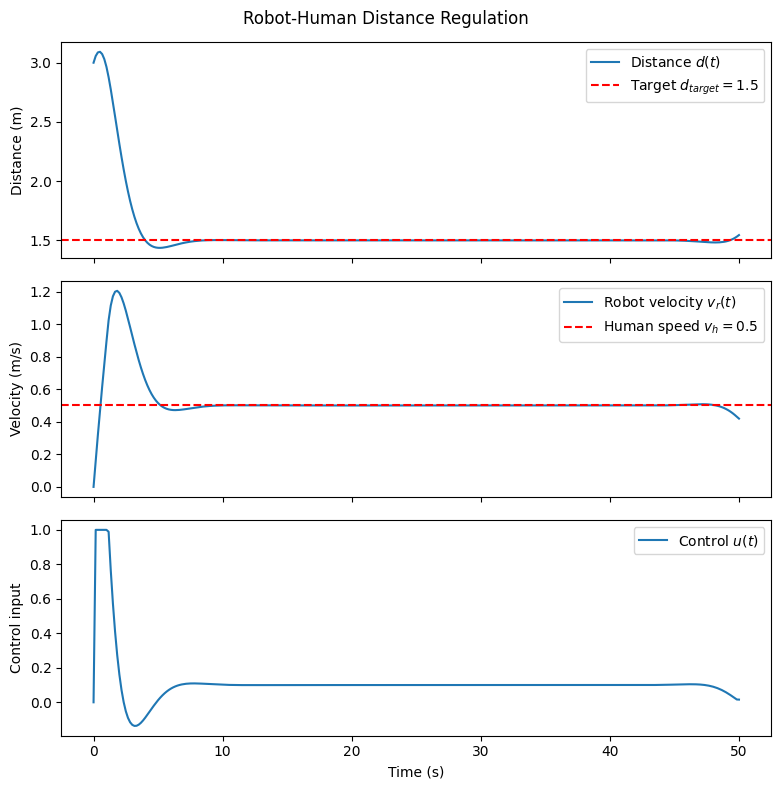

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(t_grid, d_sol, label="Distance $d(t)$")
axes[0].axhline(
    d_target, color="r", linestyle="--", label=f"Target $d_{{target}}={d_target}$"
)
axes[0].set_ylabel("Distance (m)")
axes[0].legend()

axes[1].plot(t_grid, v_r_sol, label="Robot velocity $v_r(t)$")
axes[1].axhline(v_h, color="r", linestyle="--", label=f"Human speed $v_h={v_h}$")
axes[1].set_ylabel("Velocity (m/s)")
axes[1].legend()

axes[2].plot(t_grid, u_sol, label="Control $u(t)$")
axes[2].set_ylabel("Control input")
axes[2].set_xlabel("Time (s)")
axes[2].legend()

plt.suptitle("Robot-Human Distance Regulation")
plt.tight_layout()
plt.show()
